# RIXS
The script is designed to combine multiple RIXS h5 file and plot the contour. There're three sections:
- Load and combine multiple h5 files. The case here shows 4 files.
- Plot the positions of measured spots of RIXS.
- Plot the RIXS contour along with assign cutting profiles (XAS & XES).


# Load and combine multiple h5 files

In [165]:
%matplotlib notebook
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

In [263]:
#################### What you should change ####################
ref = ['S_ref','Li2S_ref','LiTFSI_ref']
q = '7c'
a = np.linspace(3.1, 43.1, 41)
b = np.linspace(3.2, 43.2, 41)
#################### What you should change ####################
all_intensity = []
#################### What you should change ####################
for num in [1,2,3]: 
    file = r'C:\Users\oppcexpv\Downloads\252_data\252-'+q+r'\%s_rixs_000%i\%s_rixs_000%i.h5'%(ref[1],num,ref[1],num)
    file = file.replace('\\', '/')
#################### What you should change ####################    
    energy = []
    gdall = []
    I0t = []
    TSY = []
    TSZ = []
    
    f = h5py.File(file, 'r')
    for i in a:
        #print(i)
        g = f.get('%s/instrument/hdh_energy' %f'{i}')
        energy.append(np.array(g.get('data')))
        h = f.get('%s/instrument/gdall' %f'{i}')
        gdall.append(np.array(h.get('data')))
        l = f.get('%s/instrument/I0t' %f'{i}')
        I0t.append(np.array(l.get('data')))

    for i in b:
        #print(i)
        g = f.get('%s/instrument/TSY_cnt' %f'{i}')
        TSY.append(np.array(g.get('data'))[0])
        h = f.get('%s/instrument/TSZ_cnt' %f'{i}')
        TSZ.append(np.array(h.get('data'))[0])
        
    intensity = []
    for i in range(len(energy)):
        intensity.append(np.divide(gdall[i], I0t[i]))
    all_intensity.append(intensity)

#################### What you should change ####################
#Somehow, I can't get the xes_en_texs, so that's the solution
E_emi = np.linspace(2304,2312,41)

## Sum the intensity from multiple h5 files amd remove outliers

In [264]:
intensity_sum = []
for i in range(len(all_intensity[0])): #41: number of XAS scan
    for j in range(len(all_intensity[0][0])): #108: number of point in a XAS scan
        intensity_sum.append(all_intensity[0][i][j]+all_intensity[1][i][j]
                             +all_intensity[2][i][j])#+all_intensity[3][i][j])
    
intensity_final = np.reshape(intensity_sum, (len(all_intensity[0]),len(all_intensity[0][0])))

for j in range(len(intensity_final)): # 41
    for i in range(2,len(intensity_final[0])-2): # 108
        before = intensity_final[j][i-2:i].mean()
        after = intensity_final[j][i+1:i+3].mean()
        if intensity_final[j][i] > 1.3*(before + after)/2:
            intensity_final[j][i] = (before + after)/2
df = pd.DataFrame(intensity_final)

In [265]:
for j in range(len(intensity_final)): # 41
    for i in range(2,len(intensity_final[0])-2): # 108
        before = intensity_final[j][i-2:i].mean()
        after = intensity_final[j][i+1:i+3].mean()
        low =  intensity_final[j][i-2:i+3].min()
        if intensity_final[j][i]-low > 4*(before-low + after-low)/2:
            intensity_final[j][i] = (before + after)/2
df = pd.DataFrame(intensity_final)

# Plot the positions of measured spots of RIXS

<IPython.core.display.Javascript object>


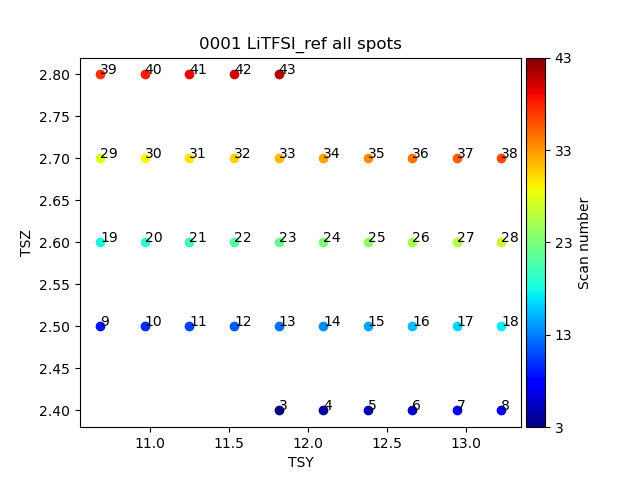

In [143]:
fig=plt.figure()

cmap = plt.cm.get_cmap("jet")
norm = mpl.colors.Normalize(vmin = 3, vmax = 43)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
colors = plt.cm.jet(np.linspace(0, 1, 43))
ticks = np.linspace(3, 43, 5)
cbar = plt.colorbar(mappable = sm, ticks=ticks, format=mpl.ticker.ScalarFormatter(), 
                    shrink=1.0, fraction=0.1, pad=0.01, label='Scan number')

for i in range(len(TSY)):
    plt.scatter(TSY[i], TSZ[i], color=colors[i])
    plt.text(TSY[i], TSZ[i], i+3)

plt.xlabel('TSY')
plt.ylabel('TSZ')
#################### What you should change ####################
plt.title('000%i %s all spots'%(num,ref[2]))
plt.savefig('000%i %s spots.png'%(num,ref[2]), bbox_inches='tight')

# Plot RIXS contour and cutting profiles

In [259]:
# input the horizontal cut
E_abs = '2471.02,2473,2484'
E_abs = E_abs.split(',')
# Select the emission energy for XANES
E_out = '2307.12,2307.37,2308,2308.6'
E_out = E_out.split(',')

<IPython.core.display.Javascript object>


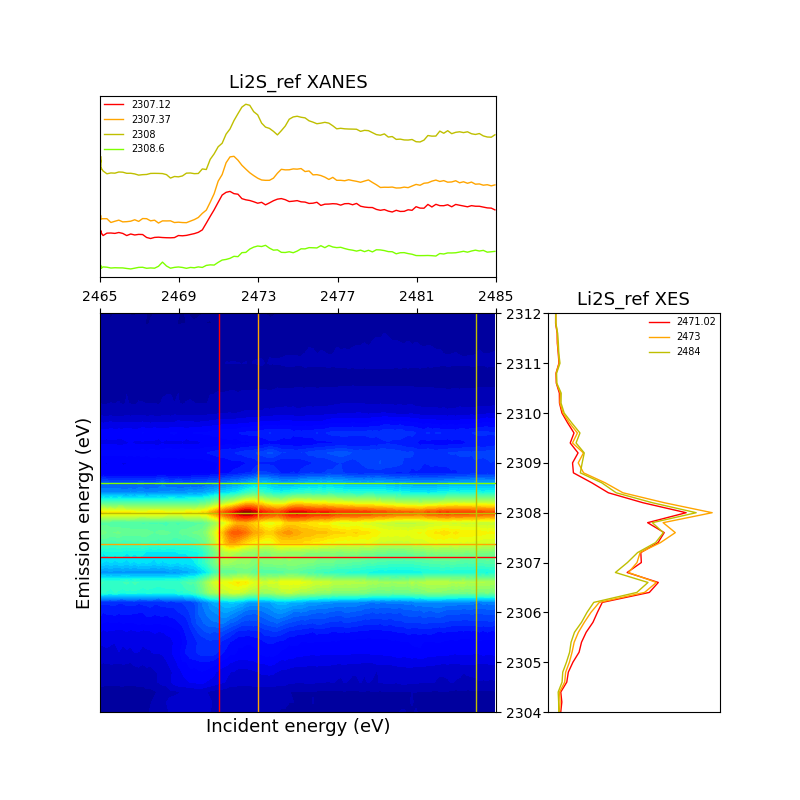

In [268]:
E_emi = np.linspace(2304,2312,41)
fig = plt.figure(figsize=(8, 8), dpi=100)
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.3)
contour = fig.add_subplot(grid[1:, 0:-1])
XAS = fig.add_subplot(grid[0, 0:-1], yticklabels=[], sharex=contour)
XES = fig.add_subplot(grid[1:, 2], xticklabels=[], sharey=contour)

colorlist=['red', 'orange', 'y',  'Chartreuse', 'c', '#4682B4', 'b', 'm']
contour.set_prop_cycle(color=colorlist)
XAS.set_prop_cycle(color=colorlist)
###############
# Select the emission energy for XANES
for w in E_out:
    w = float(w)
    for row in range(len(intensity_final)): #41
        if abs(E_emi[row]-w)<0.1:
            XAS.plot(energy[0]*1000,intensity_final[row], lw=1)
            contour.plot([2465, 2485], [w,w], lw=1)  # plot the horizontal cut line
        else:
            continue  
XAS.legend(E_out, frameon=False, fontsize=7, borderaxespad=0)
XAS.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
XAS.tick_params(axis='y', which='both', left=False, labelleft=False)
XES.set_yticks([])
#################### What you should change ####################
XAS.set_title('%s XANES'%ref[1],fontdict={'fontsize':13})
#################### What you should change ####################
###############  
contour.set_prop_cycle(color=colorlist)
XES.set_prop_cycle(color=colorlist)
for w in E_abs:
    w = float(w)
    for row in range(len(energy[0])): #108
        if abs(energy[0][row]-w*0.001)<0.00009:
            XES.plot(df[df.columns[row]], E_emi, lw=1) #41
            contour.plot([w, w], [2304, 2312],lw=1)  # plot the vertical cut line
        else:
            continue     
XES.set_autoscalex_on
XES.legend(E_abs, frameon=False, fontsize=7, borderaxespad=0)
#################### What you should change ####################
XES.set_title('%s XES'%ref[1],fontdict={'fontsize':13})
#################### What you should change ####################
XES.set_xticks([])
XES.tick_params(axis='y',
                which='both',      # both major and minor ticks are affected                         
                left=True,
                right=False,
                labelleft=False)    # labels along the bottom edge are off

###############
contour.contourf(energy[0]*1000, E_emi, intensity_final, 50, cmap='jet')
contour.set_xlim(2465, 2485)
contour.set_xticks(np.linspace(2465, 2485,6))
contour.set_yticks(np.linspace(2304, 2312,9))
contour.set_xlabel("Incident energy (eV)",fontdict={'fontsize':13})
contour.set_ylabel("Emission energy (eV)",fontdict={'fontsize':13})
contour.tick_params(axis='y',
                    which='both',      # both major and minor ticks are affected                         
                    left=False,
                    right=True,
                    labelright=True,
                    labelleft=False,
                    labelsize=10.0)    # labels along the bottom edge are off

contour.tick_params(axis='x',
                    which='both',
                    bottom=False,    # ticks along the bottom edge are off
                    top=True,    # ticks along the top edge are off
                    labelbottom=False,
                    labeltop=True,
                    labelsize=10.0)
#################### What you should change ####################
plt.savefig('%s_RIXS'%ref[1], bbox_inches='tight')
#################### What you should change ####################